In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pickle
# Define GPU device - We will run our model on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print( torch.cuda.get_device_name(device))

NVIDIA T600 Laptop GPU


In [3]:
IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# These values known for fast convergence


# transformation for good generalization of model
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1, 
                                                            saturation = 0.1), 
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])




In [ ]:
# Load the data and transform the dataset
train_dataset =  dsets.CIFAR10(root='./data', 
                               train=True, 
                               download=True, 
                               transform = composed_train)
validation_dataset = dsets.CIFAR10(root='./data', 
                                   train=False, 
                                   download=True, 
                                   transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [12]:
def train_model(model, train_loader, validation_loader, optimizer, scheduler, n_epochs=20):
    N_test = len(validation_loader.dataset)
    accuracy_list = []
    train_loss_list = []
    # device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_cost_list = []
    val_cost_list = []

    for epoch in range(n_epochs):
        print(epoch)
        train_COST = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            train_COST += loss.item()

        train_COST = train_COST / len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0

        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            val_COST += val_loss.item()

        val_COST = val_COST / len(validation_loader)
        val_cost_list.append(val_COST)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST, 4)),
              " | Validation Loss : {}".format(round(val_COST, 4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))

        # Update the learning rate
        scheduler.step(val_COST)

    return accuracy_list, train_cost_list, val_cost_list


# **Detecting & Filtering Model**

In [18]:
def resnet_34():
    # Define the resnet model
    resnet = torchvision.models.resnet34(pretrained=True)
    
    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    
    # Initialize with xavier uniform
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

model_mmtv6 = resnet_34()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv6.parameters(), 
                            lr = learning_rate, 
                            momentum = 0.2)

# Define the Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5=train_model(model=model_mmtv6, 
                                                                       n_epochs=5, 
                                                                       train_loader=train_loader, 
                                                                       validation_loader=validation_loader, 
                                                                       optimizer=optimizer, 
                                                                       scheduler = scheduler)

c:\Users\ma185511\AppData\Local\miniconda3\envs\py3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ma185511\AppData\Local\miniconda3\envs\py3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--> Epoch Number : 1  | Training Loss : 0.9233  | Validation Loss : 0.3108  | Validation Accuracy : 89.66%
--> Epoch Number : 2  | Training Loss : 0.2796  | Validation Loss : 0.2346  | Validation Accuracy : 92.11%
--> Epoch Number : 3  | Training Loss : 0.2003  | Validation Loss : 0.2026  | Validation Accuracy : 93.53%
--> Epoch Number : 4  | Training Loss : 0.1516  | Validation Loss : 0.1789  | Validation Accuracy : 94.21%
--> Epoch Number : 5  | Training Loss : 0.127  | Validation Loss : 0.1766  | Validation Accuracy : 94.49%


In [24]:
from torchsummary import summary

summary(model_mmtv6, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [19]:
# Save the model
model_mmtv6 = model_mmtv6.to(device)
pickle.dump(model_mmtv6, open('C:/Thesis/model/CNN_resnet_34.pkl', 'wb'))

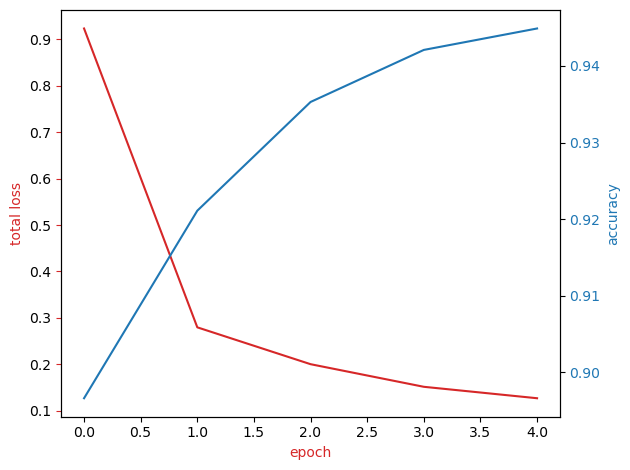

In [33]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_listv5,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list_normalv5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

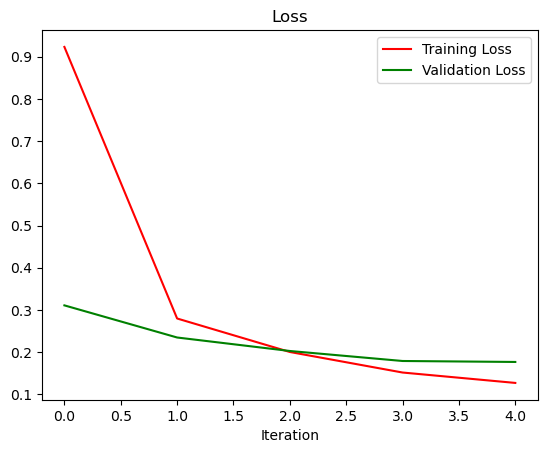

In [34]:
plt.plot(train_cost_listv5, 'r', label='Training Loss')
plt.plot(val_cost_listv5,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()

In [78]:
print(accuracy_list_normalv5)
print(train_cost_listv5)
print(val_cost_listv5)

[0.8966, 0.9211, 0.9353, 0.9421, 0.9449]
[0.9232566885352135, 0.27963509444892404, 0.20027301995456218, 0.1515804663449526, 0.12695285698398948]
[0.31075080528855326, 0.23460192196071147, 0.20263028264045715, 0.17892123449593783, 0.1766381736472249]


In [95]:
# Save array
np.save('C:\\Thesis\\data\\accuracy_list_normalv5.npy', accuracy_list_normalv5)
np.save('C:\\Thesis\\data\\train_cost_listv5.npy', train_cost_listv5)
np.save('C:\\Thesis\\data\\val_cost_listv5.npy', val_cost_listv5)


# Load array
loaded_array = np.load('C:\\Thesis\\data\\accuracy_list_normalv5.npy')
print(loaded_array)

[0.8966 0.9211 0.9353 0.9421 0.9449]


In [70]:
import pickle

# Load the model
with open('C:/Thesis/model/CNN_resnet_34.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Move the loaded model to the desired device
model_mmtv6 = loaded_model.to(device)


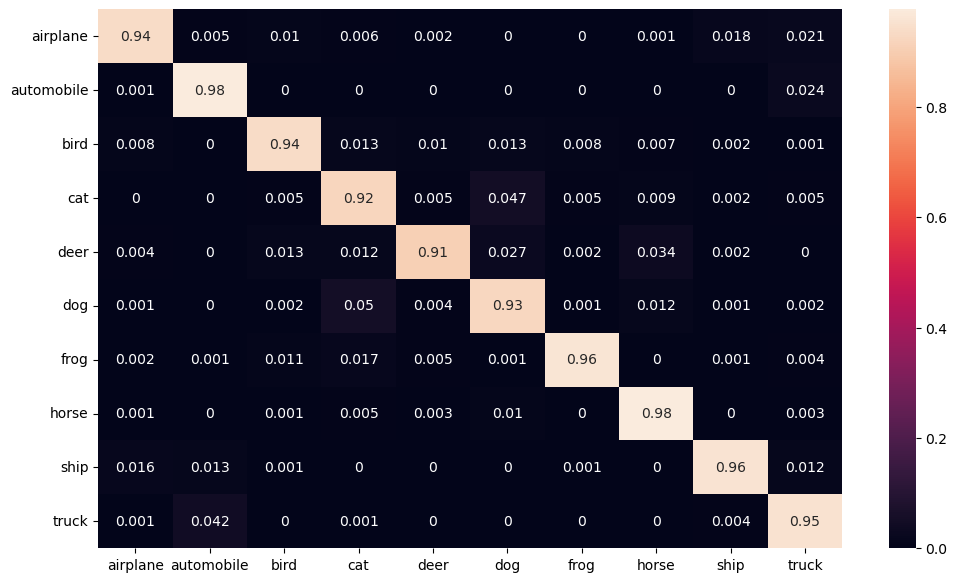

In [21]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = model_mmtv6(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [58]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1000
           1       0.94      0.97      0.96      1000
           2       0.96      0.94      0.95      1000
           3       0.90      0.92      0.91      1000
           4       0.97      0.91      0.94      1000
           5       0.90      0.93      0.92      1000
           6       0.98      0.96      0.97      1000
           7       0.94      0.98      0.96      1000
           8       0.97      0.96      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.94     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000



# **Visualizing model's performance on first 100 images:**

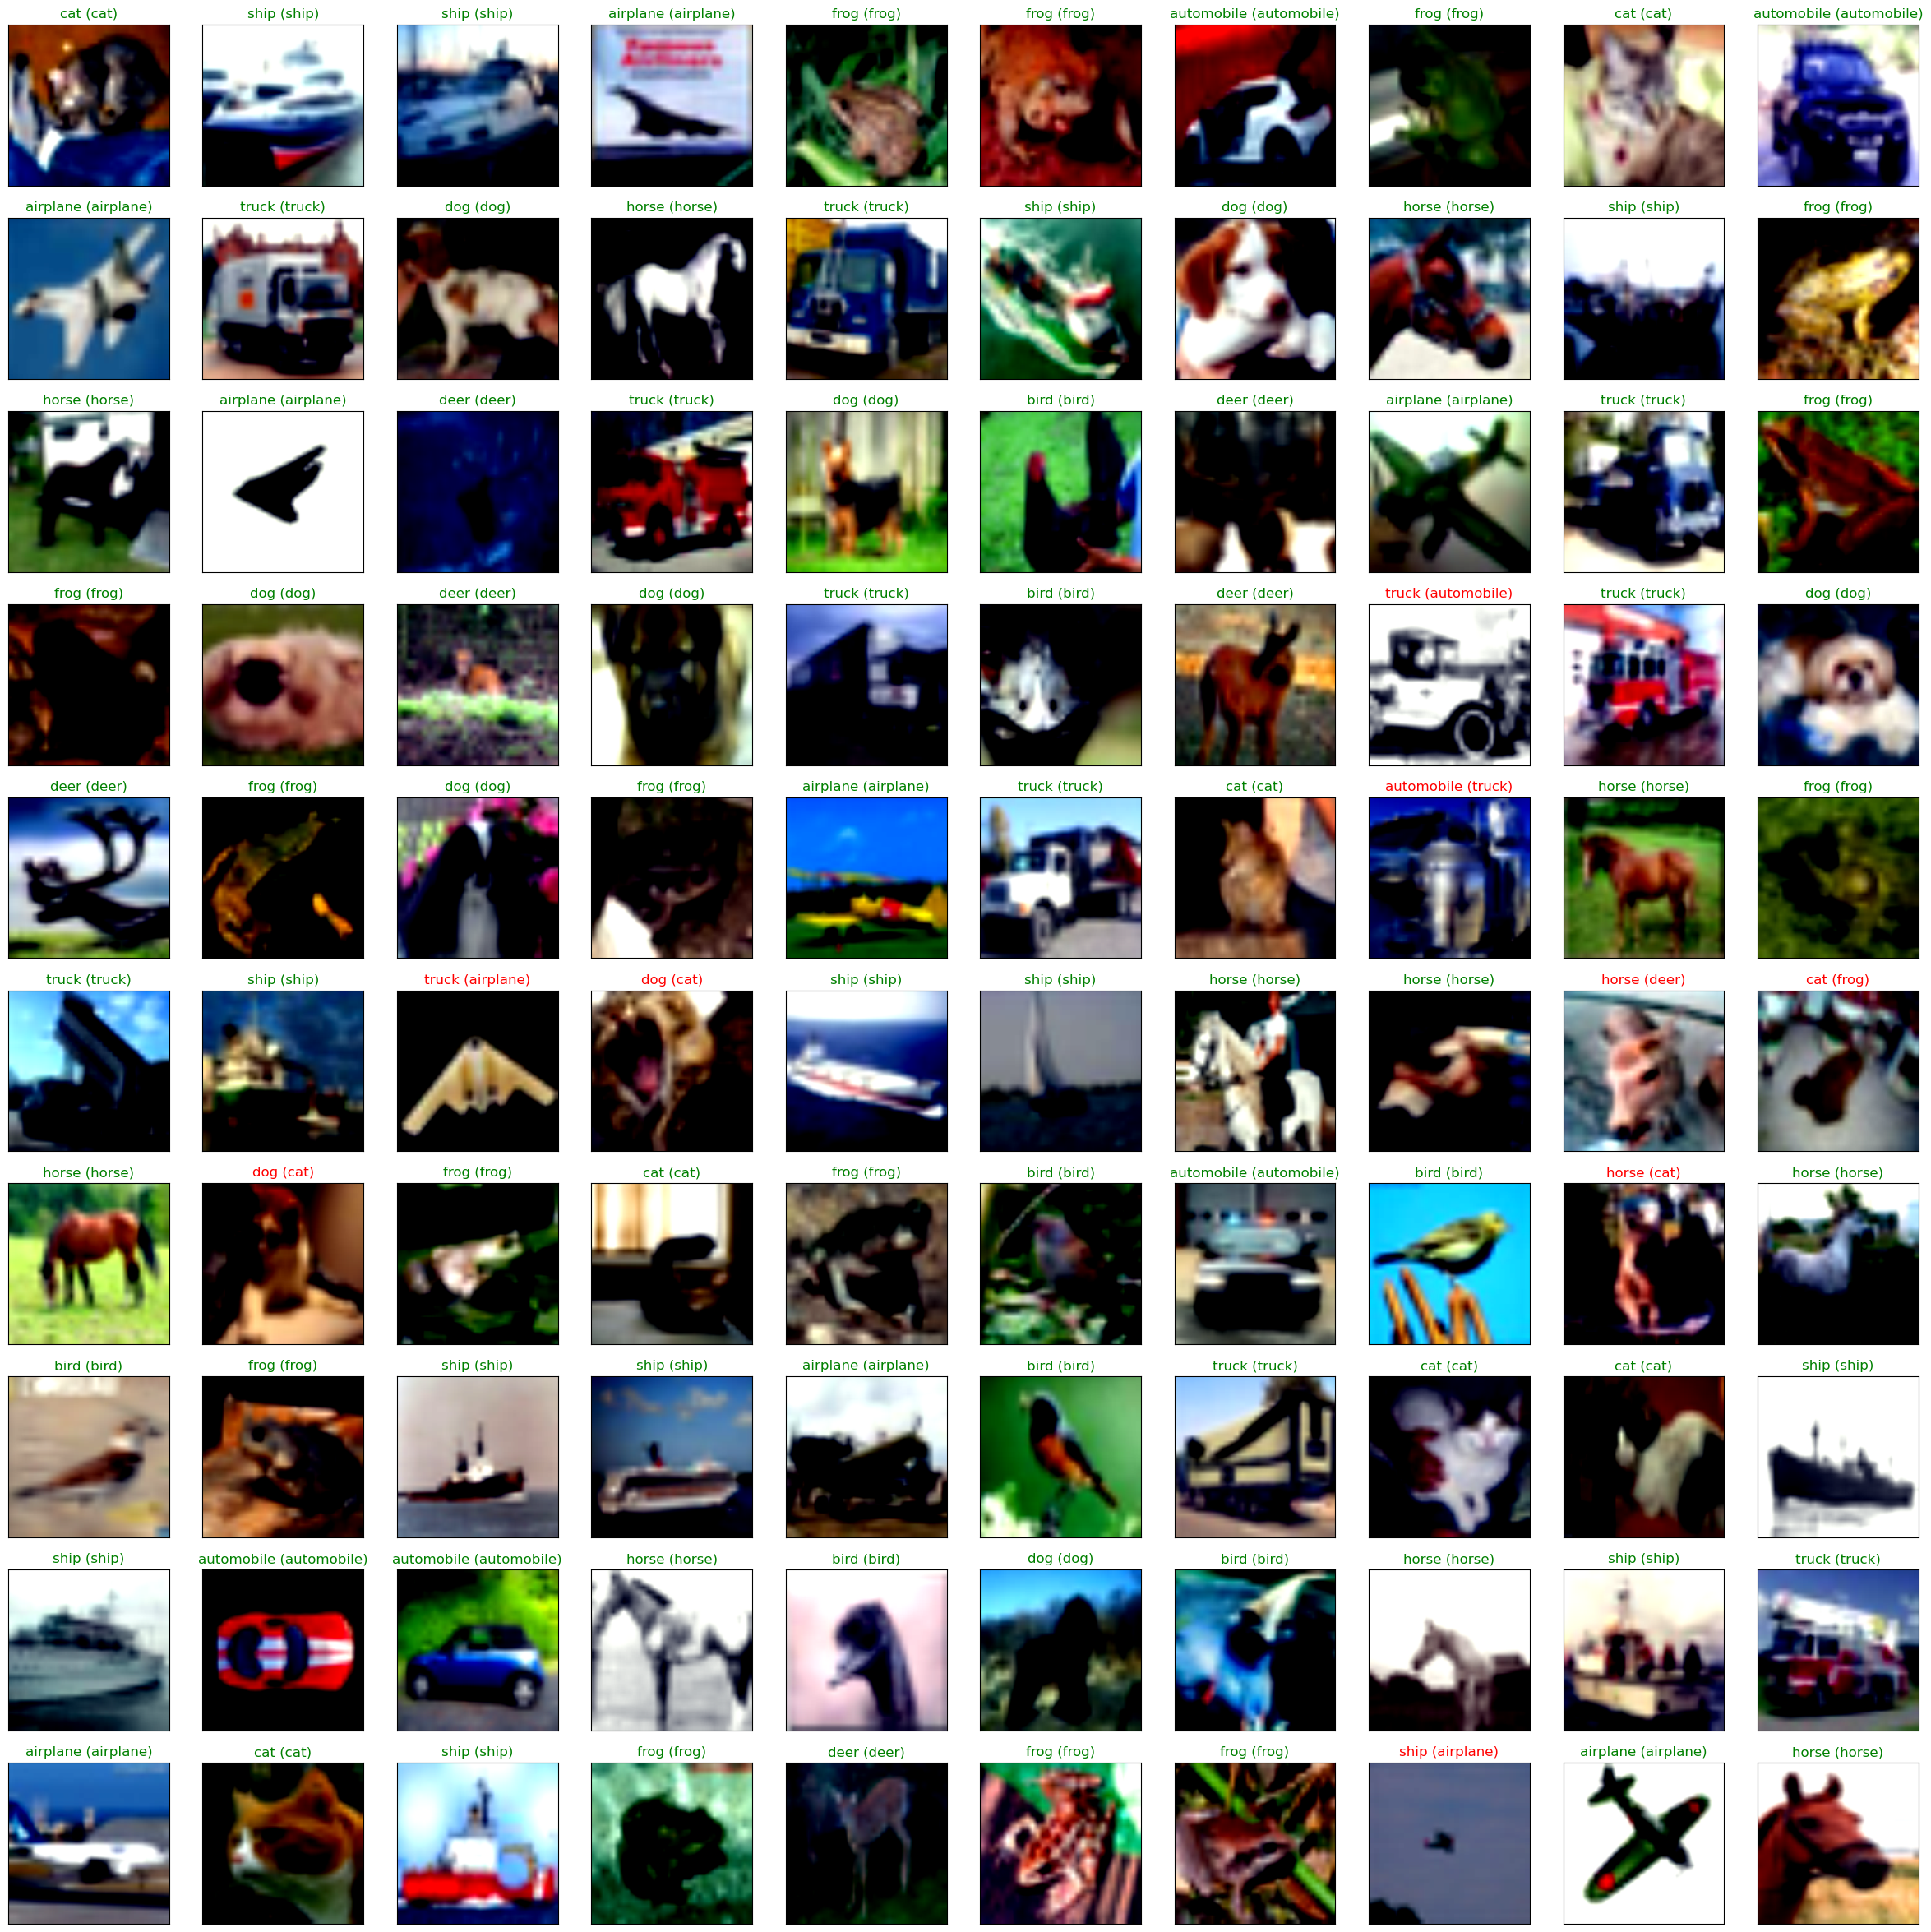

In [85]:
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images = images.to(device)
labels = labels.to(device)
output = model_mmtv6(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(30, 30))

for idx in np.arange(100):
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(class_names[preds[idx].item()]), str(class_names[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

# **Ploting the first 3 misclassified samples**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


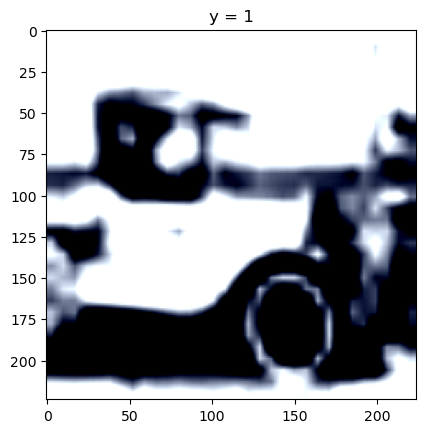

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat:  tensor([9], device='cuda:0')
Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


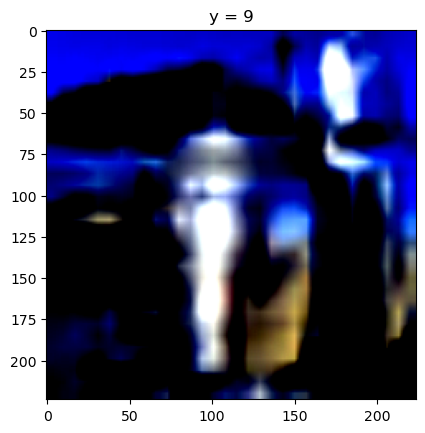

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat:  tensor([1], device='cuda:0')
Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


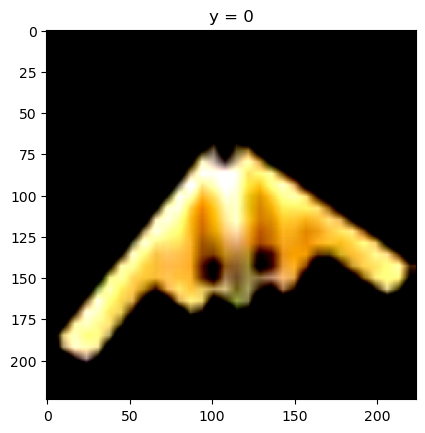

yhat:  tensor([9], device='cuda:0')


In [87]:
# Plot the mis-classified samples
count = 0
i = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = model_mmtv6(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data(validation_dataset[i])
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 3:
        break
    i+=1

# Defensive Distillation model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

test_size = 0.2 

# Load the extended dataset
x_train_extended = np.load(r'cifar10-extended\x_train_extended.npy')
y_train_extended = np.load(r'cifar10-extended\y_train_extended.npy')

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_extended, y_train_extended, test_size=test_size, random_state=42)

# Print the shapes of the resulting datasets to verify the split
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (200000, 32, 32, 3)
x_test shape: (50000, 32, 32, 3)
y_train shape: (200000, 10)
y_test shape: (50000, 10)


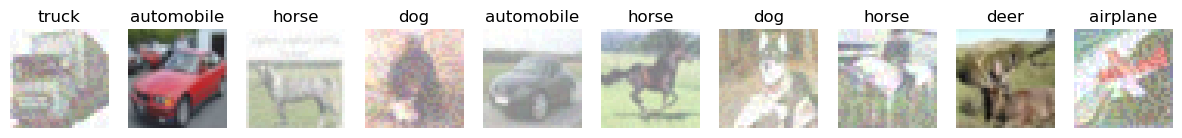

In [2]:
#visualizing trainset
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))  

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(0, x_train.shape[0])  
    ax.imshow(x_train [random_index])  
    
    label_index = np.argmax(y_train [random_index]) 
    ax.set_title(f"{class_names[label_index]}")  
    ax.axis('off')   

plt.show()

In [3]:
# one-hot encoded to index labels
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # Check if images are in the range [0, 1] and scale to [0, 255] if true
        if np.max(images) <= 1.0:
            images = images * 255.0  # Scale to [0, 255]
        self.images = images.astype(np.uint8)  # Convert to uint8
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)  # Apply transformation
        
        return image, label

In [19]:
composed_train = transforms.Compose([transforms.ToPILImage(),  # Converts np.array (uint8) to PIL Image
                                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1, 
                                                            saturation = 0.1), 
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])

composed_test = transforms.Compose([
    transforms.ToPILImage(),  # Converts np.array (uint8) to PIL Image
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean, std)  # Normalize the tensor
])




In [21]:
composed_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image
    transforms.RandomRotation(20),  # Randomly rotate some images by 20 degrees
    transforms.RandomHorizontalFlip(0.1),  # Randomly horizontal flip the images
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Adjust color jitter
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # Adjust sharpness
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean, std),  # Normalize the images
    transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)  # Random erasing
])


In [22]:
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import numpy as np

# Apply transformations and convert PIL images back to tensors
def apply_transforms(pil_img, transform):
    return transform(pil_img)




def array_to_pil(image_array):
    # Normalize the float64 image data to 0-255 and convert to uint8
    if image_array.dtype == np.float64:
        # Normalize to 0-1 range if not already
        image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
        # Scale to 0-255 and convert to uint8
        image_array = (255 * image_array).astype(np.uint8)

    return Image.fromarray(image_array)

# Convert the entire dataset
x_train_pil = [array_to_pil(x) for x in x_train]


# Apply transformations
x_train_transformed = torch.stack([apply_transforms(img, composed_train) for img in x_train_pil])



# Ensure y_train is a tensor of the correct type, torch.long
y_train = y_train.long()  # Only if not already long type

# Create TensorDataset
train_data = TensorDataset(x_train_transformed, y_train)

# Create DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 602112 bytes.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def imshow(img):
    # Unnormalize the image for display
    img = img / 2 + 0.5  # Assuming normalization is mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis numbers and ticks

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot images
plt.figure(figsize=(10, 10))
imshow(vutils.make_grid(images[:16], nrow=4, padding=2, normalize=True))
plt.show()


In [17]:
# Load the data and transform the dataset

# Create datasets
train_dataset = CustomDataset(x_train, y_train, transform=composed_train)
validation_dataset = CustomDataset(x_test, y_test, transform=composed_test)

# Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

In [9]:
def resnet_34():
    resnet = torchvision.models.resnet34(pretrained=True)
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

In [10]:
model_ddv1 = resnet_34()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_ddv1.parameters(), 
                            lr = learning_rate, 
                            momentum = 0.2)

# Define the Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')



c:\Users\ma185511\AppData\Local\miniconda3\envs\py3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ma185511\AppData\Local\miniconda3\envs\py3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5=train_model(model=model_ddv1, 
                                                                       n_epochs=5, 
                                                                       train_loader=train_loader, 
                                                                       validation_loader=validation_loader, 
                                                                       optimizer=optimizer, 
                                                                       scheduler = scheduler)

0


KeyboardInterrupt: 

In [ ]:
# Save the model
model_ddv1 = model_ddv1.to(device)
pickle.dump(model_ddv1, open('C:/Thesis/model/CNN_resnet_34_ddv1.pkl', 'wb'))

In [ ]:
from torchsummary import summary

summary(model_mmtv6, input_size=(3, 224, 224))

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_listv5,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list_normalv5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

In [ ]:
plt.plot(train_cost_listv5, 'r', label='Training Loss')
plt.plot(val_cost_listv5,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()

In [ ]:
print(accuracy_list_normalv5)
print(train_cost_listv5)
print(val_cost_listv5)

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = model_mmtv6(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images = images.to(device)
labels = labels.to(device)
output = model_mmtv6(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(30, 30))

for idx in np.arange(100):
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(class_names[preds[idx].item()]), str(class_names[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))